# SOLA Operator Construction, Model Reconstruction, and Profiling

This notebook demonstrates the construction and profiling of SOLA operators for interval problems using pygeoinf. It covers domain setup, operator creation, model reconstruction, and performance analysis.

In [1]:
# Import Required Libraries
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace, LinearOperator
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver, LUSolver
import numpy as np
import matplotlib.pyplot as plt
import time
import cProfile
import pstats
import io

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


In [2]:
# Define Function Domain and Spaces
function_domain = IntervalDomain(0, 1)
M = L2Space(10, function_domain)
N_d = 30
D = EuclideanSpace(N_d)
N_p = 5
P = EuclideanSpace(N_p)
width = 0.2
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p)

In [3]:
# Create Normal Modes and Target Providers
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10), freq_range=(5, 10), random_state=40)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)

In [4]:
# Construct SOLA Operators
G = SOLAOperator(M, D, normal_modes_provider, integration_method='simpson', n_points=100)
T = SOLAOperator(M, P, target_provider, integration_method='simpson', n_points=100)

In [5]:
# Create and Plot True Model
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
# Generate Data and Add Noise
d_bar = G(m_bar)
d_tilde = d_bar + np.random.normal(-0.1*np.max(d_bar), 0.1*np.max(d_bar), d_bar.shape)

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


In [6]:
# Compute Normal Operator and Its Inverse
Lambda = LinearOperator.from_matrix(D, D, G.compute_gram_matrix())
cholesky_solver = CholeskySolver(galerkin=True)
Lambda_inv = cholesky_solver(Lambda)
G_inv = G.adjoint @ Lambda_inv

In [7]:
# Reconstruct Model from Data
m_tilde = G_inv(d_bar)
m_tilde_noisy = G_inv(d_tilde)

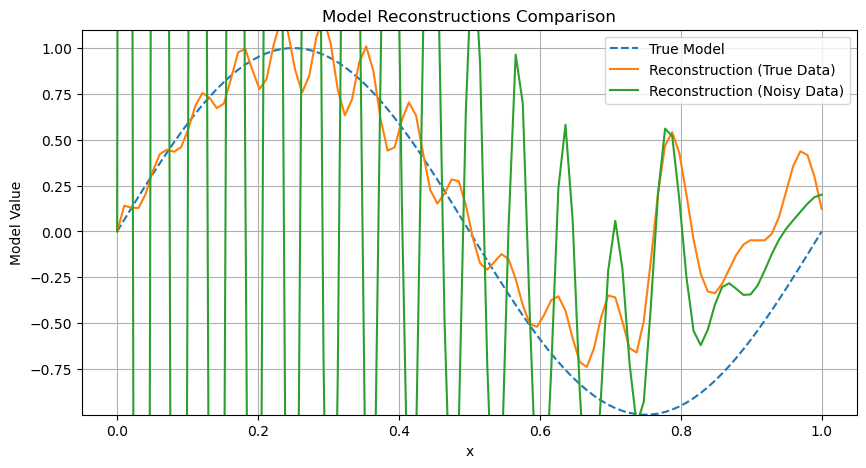

In [8]:
x = function_domain.uniform_mesh(100)
# Evaluate and Compare Reconstructions
plt.figure(figsize=(10, 5))
plt.plot(x, m_bar.evaluate(x), label='True Model', linestyle='--')
plt.plot(x, m_tilde.evaluate(x), label='Reconstruction (True Data)')
plt.plot(x, m_tilde_noisy.evaluate(x), label='Reconstruction (Noisy Data)')
plt.ylim(np.max(m_bar.evaluate(x)) * -1, np.max(m_bar.evaluate(x)) * 1.1)
plt.title('Model Reconstructions Comparison')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Project Models to Property Space
p_bar = T(m_bar)
p_tilde = T(m_tilde)
p_tilde_noisy = T(m_tilde_noisy)

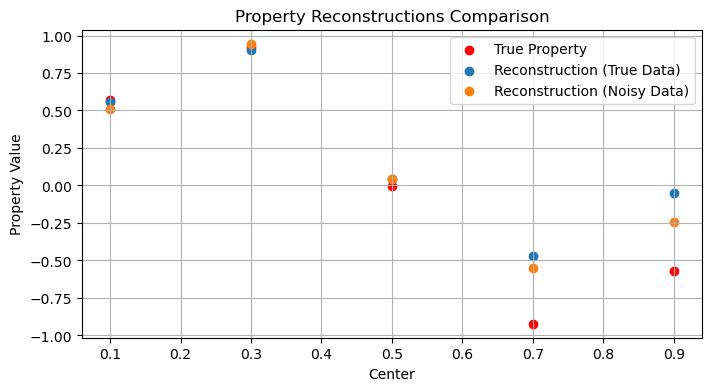

In [10]:
# Compare Property Reconstructions
plt.figure(figsize=(8, 4))
plt.scatter(centers, p_bar, label='True Property', color='red')
plt.scatter(centers, p_tilde, label='Reconstruction (True Data)')
plt.scatter(centers, p_tilde_noisy, label='Reconstruction (Noisy Data)')
plt.title('Property Reconstructions Comparison')
plt.xlabel('Center')
plt.ylabel('Property Value')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Benchmark Operator Application
start = time.time()
p_bar_result = T(m_bar)
time_T_m_bar = time.time() - start
print(f"Time to compute T(m_bar): {time_T_m_bar:.6f} seconds")

start = time.time()
p_tilde_result = T(m_tilde)
time_T_m_tilde = time.time() - start
print(f"Time to compute T(m_tilde): {time_T_m_tilde:.6f} seconds")

speedup_T = time_T_m_tilde / time_T_m_bar if time_T_m_bar > 0 else float('inf')
print(f"T(m_tilde) is {speedup_T:.2f} times slower than T(m_bar)")

Time to compute T(m_bar): 0.001390 seconds
Time to compute T(m_tilde): 0.012335 seconds
T(m_tilde) is 8.88 times slower than T(m_bar)


In [12]:
# Profile Operator Application
pr = cProfile.Profile()
pr.enable()
T_m_tilde_result = T(m_tilde)
pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumtime')
ps.print_stats(20)  # Show top 20 functions by cumulative time
print(s.getvalue())

         9318 function calls (8673 primitive calls) in 0.018 seconds

   Ordered by: cumulative time
   List reduced from 123 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.018    0.009 /home/adrian/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3541(run_code)
        2    0.000    0.000    0.018    0.009 {built-in method builtins.exec}
        1    0.000    0.000    0.018    0.018 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/hilbert_space.py:438(__call__)
        1    0.000    0.000    0.018    0.018 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/sola_operator.py:71(mapping)
        1    0.000    0.000    0.018    0.018 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/sola_operator.py:115(_project_function)
        5    0.000    0.000    0.018    0.004 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_space.py:206(inner_product)
        5    0.000    0.

Method: simpson, Points: 10, Value: -0.283795, Time: 0.0024s
Method: simpson, Points: 20, Value: -0.497137, Time: 0.0030s
Method: simpson, Points: 50, Value: -0.470560, Time: 0.0022s
Method: simpson, Points: 100, Value: -0.469961, Time: 0.0021s
Method: simpson, Points: 200, Value: -0.470251, Time: 0.0025s
Method: simpson, Points: 500, Value: -0.470250, Time: 0.0041s
Method: trapz, Points: 10, Value: -0.507414, Time: 0.0021s
Method: trapz, Points: 20, Value: -0.531315, Time: 0.0020s
Method: trapz, Points: 50, Value: -0.468721, Time: 0.0027s
Method: trapz, Points: 100, Value: -0.470276, Time: 0.0022s
Method: trapz, Points: 200, Value: -0.470249, Time: 0.0025s
Method: trapz, Points: 500, Value: -0.470250, Time: 0.0031s
Method: adaptive, Points: 10, Value: -0.470250, Time: 0.7541s
Method: adaptive, Points: 20, Value: -0.470250, Time: 0.7343s
Method: adaptive, Points: 50, Value: -0.470250, Time: 0.7410s
Method: adaptive, Points: 100, Value: -0.470250, Time: 0.7207s
Method: adaptive, Points:

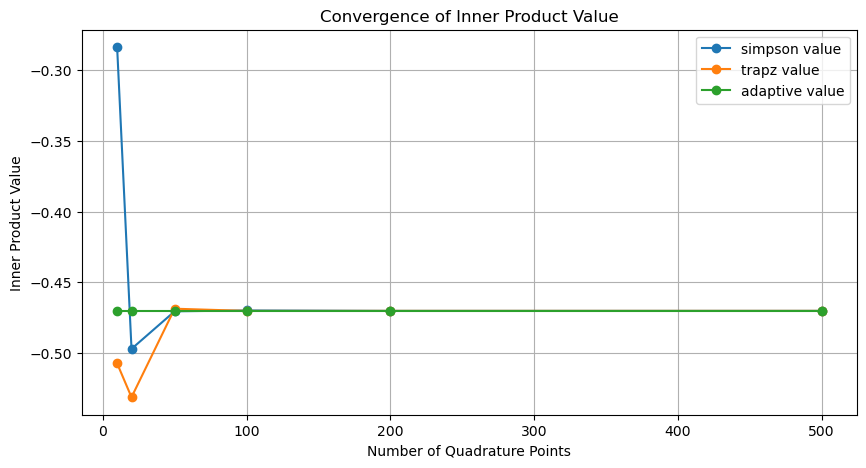

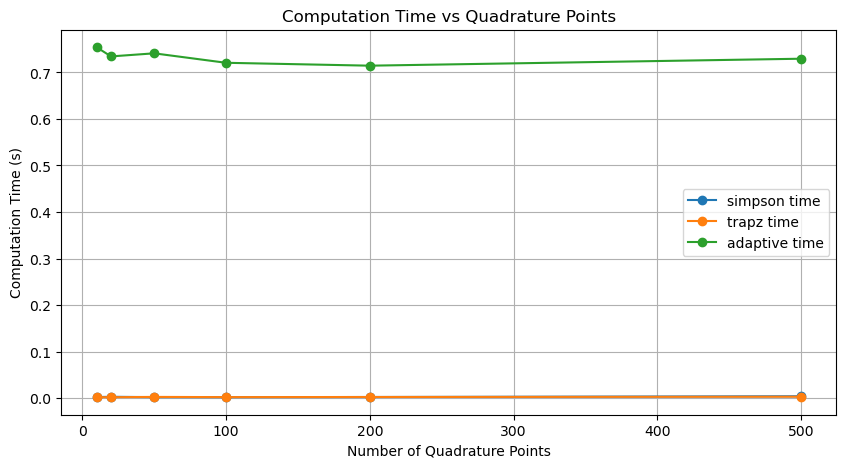

In [13]:
# Explore Effect of Integration Method and Number of Quadrature Points
from collections import defaultdict

methods = ['simpson', 'trapz', 'adaptive']
n_points_list = [10, 20, 50, 100, 200, 500]
results = defaultdict(list)
times = defaultdict(list)

bump = target_provider.get_function_by_index(3)

for method in methods:
    for n_points in n_points_list:
        start = time.time()
        val = M.inner_product(bump, m_tilde, method=method, n_points=n_points)
        elapsed = time.time() - start
        results[method].append(val)
        times[method].append(elapsed)
        print(f"Method: {method}, Points: {n_points}, Value: {val:.6f}, Time: {elapsed:.4f}s")

# Plot convergence of integral value
plt.figure(figsize=(10, 5))
for method in methods:
    plt.plot(n_points_list, results[method], marker='o', label=f'{method} value')
plt.xlabel('Number of Quadrature Points')
plt.ylabel('Inner Product Value')
plt.title('Convergence of Inner Product Value')
plt.legend()
plt.grid()
plt.show()

# Plot computation time
plt.figure(figsize=(10, 5))
for method in methods:
    plt.plot(n_points_list, times[method], marker='o', label=f'{method} time')
plt.xlabel('Number of Quadrature Points')
plt.ylabel('Computation Time (s)')
plt.title('Computation Time vs Quadrature Points')
plt.legend()
plt.grid()
plt.show()

In [14]:
# Detect Convergence for Each Integration Method
threshold = 1e-5  # Change this value for your desired accuracy
convergence_points = {}

for method in methods:
    vals = results[method]
    for i in range(1, len(vals)):
        diff = abs(vals[i] - vals[i-1])
        if diff < threshold:
            convergence_points[method] = n_points_list[i]
            break
    else:
        convergence_points[method] = None  # Not converged within tested range

for method in methods:
    if convergence_points[method] is not None:
        print(f"{method} converged at {convergence_points[method]} points (threshold={threshold})")
    else:
        print(f"{method} did not converge within tested points (threshold={threshold})")

simpson converged at 500 points (threshold=1e-05)
trapz converged at 500 points (threshold=1e-05)
adaptive converged at 20 points (threshold=1e-05)
